In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Markov Model

In [30]:
datain = pd.read_csv("datasets/csv1.csv")
datain['Date'] = pd.to_datetime(datain['Date'])
datalist = datain['Value'].to_numpy()
dsize = datalist.size
dsize

551

In [48]:
# function to discretize the state space
def discretize_thresholds(dataseries, boundaries):
    """
    Input:
        dataseries: time series. NumPy Array of dimensions (n, )
        boundaries: boundary values between states. List or rank-1 Numpy array
                    categories will be (-inf, boundaries[0]], (boundaries[0], boundaries[1]], ...,
                                       (boundaries[-2], boundaries[-1]], (boundaries[-1], inf)
    Output:
        states: discretized states. NumPy Array of dimensions (n, )
    """
    # copy time series data
    discretized = np.copy(dataseries)
    new_bounds = np.concatenate([np.array([-np.inf]), boundaries, np.array([np.inf])])
    
    # transform data into range categories
    state = 0
    for low, high in zip(new_bounds[:-1], new_bounds[1:]):
        discretized[(low < discretized) & (discretized <= high)] = state
        state += 1
    
    return discretized.astype("int64"), new_bounds

In [93]:
thresholds = [12.5, 23]
observed_states, _ = discretize_thresholds(datalist, thresholds)

min_state, max_state = np.min(observed_states), np.max(observed_states)
n_states = (max_state - min_state + 1)
print(n_states)

3


In [98]:
def generate_right_markov(order=1):   # order = how far to go back (i.e. state t depends on state t-order)
    # count the transitions
    data_int = observed_states - min_state
    pre = data_int[:-order]
    post = data_int[order:]
    markov = np.zeros((n_states, n_states))
    for a,b in zip(pre,post):
        markov[a, b] += 1.
    
    # save a frequency matrix copy
    frequencies = np.copy(markov).astype('int64')
    
    # normalize to keep sum of rows = 1
    markov = markov / np.sum(markov, axis=1, keepdims=True)    
    
    return markov, frequencies

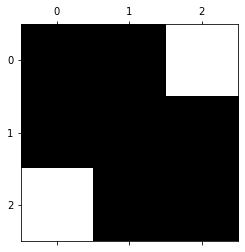

In [99]:
order = 1
markov, freq = generate_right_markov(order)
plt.spy(markov)

In [100]:
freq

array([[ 67,   4,   0],
       [  4, 458,   3],
       [  0,   3,  11]], dtype=int64)

# Predict one point ahead from observed data & compare

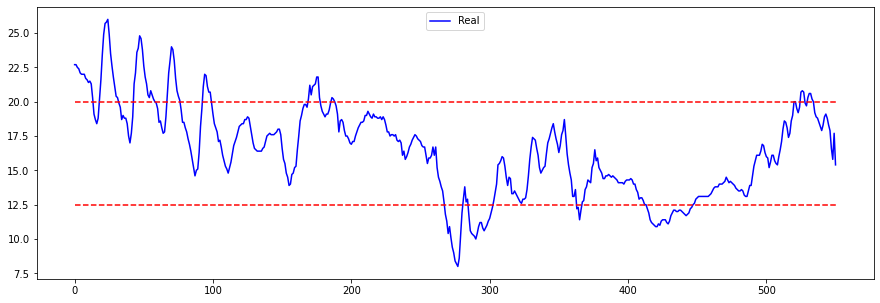

In [80]:
x_axis = np.arange(dsize)

plt.figure(figsize=(15,5))
plt.plot(x_axis, datalist, color="b", label="Real")

# plot threshold lines
for thres in thresholds:
    plt.plot(x_axis, thres*np.ones(len(x_axis)), color="r", linestyle='dashed')

plt.legend(loc=9)
plt.savefig("fig-markov-modeled.png")

# Random walks on Markov Graph

show one random walk in the future + its log-probability (not pure probability to avoid underflow)

In [18]:
def random_walk(n_steps):
    log_prob = 0.
    rng = np.random.default_rng()
    state = observed_states[-1]
    future_states = [state]

    for i in range(n_steps):
        possible_transitions = markov[state - min_state].nonzero()[0]
        new_state = rng.choice(possible_transitions) + min_state     # visit random adjacent node on graph
        log_prob += np.log(markov[state-min_state, new_state-min_state])
        future_states.append(new_state)
        state = new_state
    
    return {'log_prob': log_prob, 'path': np.array(future_states) / (10**decimal)}

CPU times: total: 1min 7s
Wall time: 1min 7s


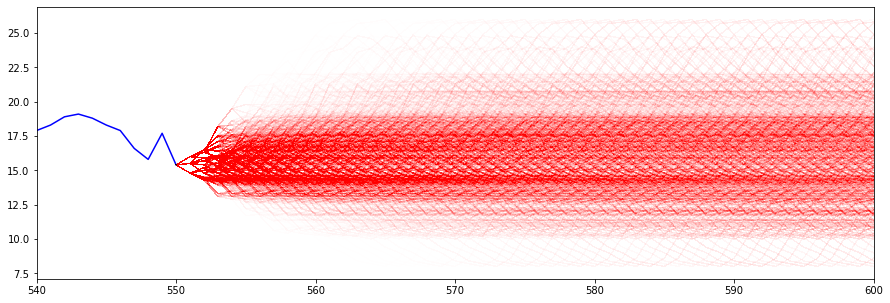

In [20]:
%%time
ahead = 100
future_x = np.arange(dsize-1, dsize + ahead)
myfig = plt.figure(figsize=(15,5))
plt.plot(x_axis, datalist, color="b")
# plt.plot(future_x, max_path['path'], color="r", linestyle='dotted')
for i in range(10000):
    walk = random_walk(ahead)
    plt.plot(future_x, walk['path'], color="r", linestyle='solid', alpha=0.002)
plt.xlim(540, 600)
# plt.ylim(0.5,4.0)
plt.savefig('markov-walk2.png')